# K MEANS AND KMEDOIDS IMPLEMENTATION

In [1]:
import numpy as np
from typing import NamedTuple, Tuple
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Arc
from numba import njit,jit, config #High performance JIT compiler and parallelization libraries

In [2]:
X_data = np.loadtxt("s3.txt")

In [3]:
class Mixture(NamedTuple):
    """Tuple holding a mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds mean
    var: np.ndarray  # (K, ) array - corresponds to the variance
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component

In [4]:
#@njit
def init(X: np.ndarray, K: int, seed: int = 0, mode : str = "Classic" ) -> Tuple[Mixture, np.ndarray]:
    """Initializes the model 

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed
        mode: Classic: Random init or K++: Kmeans ++
    Returns:
        mixture: the initialized mixture
        post: (n, K) array holding the counts for all points

    """
    np.random.seed(seed)
    n, d = X.shape
    p = np.ones(K) / K
    mu = np.zeros((K,d))
    weights= np.ones(n)
    
    # select K random points as initial means
    if mode in ["Classic"]:
        mu = X[np.random.choice(n, K, replace=False)]
        #print(mu)
    
    # K-means ++
    if mode in ["K++"]:
        for k in range(1,K+1):
            weights = weights / weights.sum()
            mu[k-1,:] = X[np.random.choice(n,1, p=weights)]
            for i in range(n):
                tiled_vector = np.tile(X[i, :], (k, 1))
                mu_vector = mu[0:k,:]
                sse = ((tiled_vector - mu_vector)**2).sum(axis=1)
                j = np.argmin(sse)
                weights[i] = sse[j]

    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((X - mu[j])**2).mean()

    mixture = Mixture(mu, var, p)
    # Matrix containing the cluster association
    post = np.ones((n, K))

    return mixture, post

In [5]:
def plot(X: np.ndarray, mixture: Mixture, post: np.ndarray,
         title: str):
    """Plots 2D data"""
    _, K = post.shape

    percent = post / post.sum(axis=1).reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.title.set_text(title)
    color = ["r", "b", "k", "y", "m", "c","g","r", "b", "k", "y", "m", "c","g","r"]
    
    cluster_association = np.zeros(post.shape[0])
    for i in range(post.shape[0]):
        cluster_association[i] = np.argmax(post[i,:])

    ax.scatter(X[:,0], X[:,1], c=cluster_association)
    for j in range(K):
        mu_ = mixture.mu[j]
        circle = Circle(mu_, np.sqrt(mixture.var[j]), color=color[j], fill=False)
        ax.add_patch(circle)
        legend = "mu_{:d} = ( {:0.3f}, {:0.3f})\n".format(j,mu_[0], mu_[1])
        ax.text(mu_[0], mu_[1], legend)
    
    plt.show()

In [6]:
#@njit
def KMeans(X: np.ndarray, mixture: Mixture) -> np.ndarray:
    """Performs Clustering using KMeans method

    Args:
        X: (n, d) array holding the data
        mixture: holds the means, var and weights

    Returns:
        mixture: the updateded mixture
        post: (n, K) array holding the counts for all points
        cost = current cost of the step

        """
    n, d = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    for i in range(n):
        tiled_vector = np.tile(X[i, :], (K, 1))
        sse = ((tiled_vector - mixture.mu)**2).sum(axis=1)
        j = np.argmin(sse)
        post[i, j] = 1
    
    n_hat = post.sum(axis=0)
    p = n_hat / n

    cost = 0
    mu = np.zeros((K, d))
    var = np.zeros(K)

    for j in range(K):
        mu[j, :] = post[:, j] @ X / n_hat[j]
        sse = ((mu[j] - X)**2).sum(axis=1) @ post[:, j]
        cost += sse
        var[j] = sse / (d * n_hat[j])

    return Mixture(mu, var, p), cost , post

In [7]:
def KMedoids(X: np.ndarray, mixture: Mixture) -> np.ndarray:
    """Performs Clustering using KMedoids method

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        mixture: the updateded mixture
        post: (n, K) array holding the counts for all points
        cost = current cost of the step

        """
    n, d = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    for i in range(n):
        tiled_vector = np.tile(X[i, :], (K, 1))
        sse = ((tiled_vector - mixture.mu)**2).sum(axis=1)
        j = np.argmin(sse)
        post[i, j] = 1

    n_hat = post.sum(axis=0)
    p = n_hat / n

    cost = 0
    mu = np.zeros((K, d))
    var = np.zeros(K)
    
    for j in range(K):
        points_cluster_j = np.diag(post[:, j]) @ X
        points_cluster_j = points_cluster_j[[i for i, x in enumerate(points_cluster_j) if x.any()]]
        min_sse = None
        for i , point in enumerate(points_cluster_j):
            X_del = np.delete(points_cluster_j,i,0)
            sse = ((point - X_del)**2).sum(axis=1).sum(axis=0)
            if min_sse is None or sse < min_sse:
                min_sse = sse
                mu[j] = point         
        cost += min_sse
        var[j] = min_sse / (d * n_hat[j])

    return Mixture(mu, var, p), cost , post

In [8]:
#@njit   
def run(X: np.ndarray, mixture: Mixture,
        post: np.ndarray, method : str = "KMeans" ) -> Tuple[Mixture, np.ndarray, float]:
    """Runs the model choosing between -KMeans or Kmedoid

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the counts for all points

    Returns:
        Mixture: the new mixture
        post np.ndarray: (n, K) array holding the counts for all points
        float: cost of the current assignment
    """

    prev_cost = None
    cost = None
    if method in ["KMeans"]:
        while (prev_cost is None or prev_cost - cost > 1e-4):
            prev_cost = cost
            mixture, cost , post= KMeans(X, mixture)
            
    if method in ["KMedoids"]:
        while (prev_cost is None or prev_cost - cost > 1e-4):
            prev_cost = cost
            mixture, cost , post= KMedoids(X, mixture)
    return mixture, post, cost

In [24]:
#@njit
def test_methods(X_data , initialization: str = "Classic", method : str = "KMeans", n : int= 15):
    #iterable around different number of clusters
    for K in range(n,n+1):
        min_cost = None
        best_seed = None
        for seed in range(0, 10):
            mixture, post = init(X_data, K, seed)
            mixture, post, cost = run(X_data, mixture, post)
            if min_cost is None or cost < min_cost:
                min_cost = cost
                best_seed = seed 
        mixture, post = init(X_data, K, best_seed,initialization)
        mixture, post, cost = run(X_data, mixture, post,method)
        print("Your cost using best seed:",format(min_cost,'.1E'))
        plot(X_data, mixture, post, initialization+method)

In [17]:
#time test_methods("Classic","KMeans")
#time test_methods("K++","KMedoids")
#time test_methods("Classic","KMedoids")

Your cost using best seed: 1.7E+13


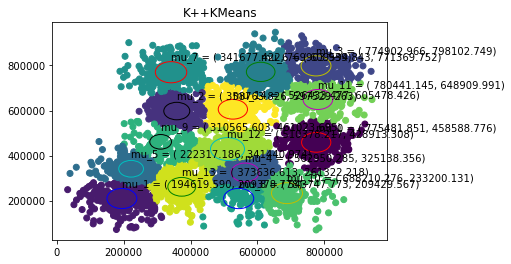

CPU times: user 1min 37s, sys: 913 ms, total: 1min 38s
Wall time: 25.8 s


In [18]:
time test_methods(X_data, "K++","KMeans")

In [22]:
def screen_plot(X_data, initialization: str = "Classic", method : str = "KMeans", n : int = 20):
    cost_vector = []
    #iterable around different number of clusters
    for K in range(2,n):
        min_cost = None
        best_seed = None
        for seed in range(0, 1):
            mixture, post = init(X_data, K, seed)
            mixture, post, cost = run(X_data, mixture, post)
            if min_cost is None or cost < min_cost:
                min_cost = cost
                best_seed = seed
                cost_vector.append(min_cost)
    plt.plot(range(2,n), cost_vector)                
#mixture, post = init(X_data, K, best_seed,initialization)
#mixture, post, cost = run(X_data, mixture, post,method)
#print("Your cost using best seed:",format(min_cost,'.1E'))
#plot(X_data, mixture, post, initialization+method)

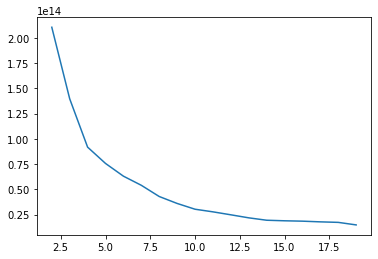

In [23]:
screen_plot(X_data)

Your cost using best seed: 5.0E+13


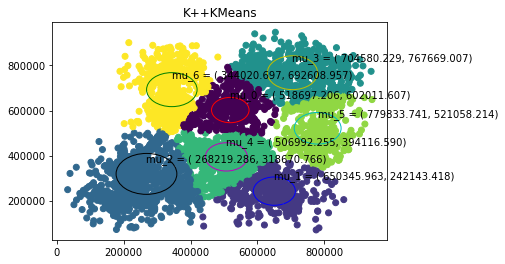

CPU times: user 1min 34s, sys: 848 ms, total: 1min 35s
Wall time: 24.4 s


In [25]:
#using screen plot data (knee localized at 7 clusters)
time test_methods(X_data, "K++","KMeans",7)

# Fuzzyy C-Means

In [108]:
def init(X: np.ndarray, K: int, m: int=2, seed: int = 0) -> np.ndarray:
    """Initializes the model with random points as initial
    means and uniform assingments

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed

    Returns:
        Matrix containing the weights 

    """
    np.random.seed(seed)
    n, d = X.shape
    U = np.random.dirichlet(np.ones(K),n)
    return U

In [109]:
def Fuzzy(X: np.ndarray, U: np.ndarray , m: int = 2) -> np.ndarray:
    """Performs Clustering using Fuzzy KMeans method

    Args:
        X: (n, d) array holding the data
        mixture: the current mixture
        m : "Fuzzyness"
    Returns:
        Matrix containing the weights 
        mu : means

        """
    n, d = X.shape
    _, K = U.shape
    mu = np.zeros((K,d))
    U_send = np.zeros((n,K))
    
    for j in range(K):
        mu[j, :] = (U[:, j]**m) @ X / ((U[:, j]**m).sum())

    for i in range(n):
        for j in range(K):
            sum_U_denom= 0
            nom = ((X[i,:] - mu[j])**2).sum(axis=0)
            for l in range(K):
                denom = ((X[i,:] - mu[l])**2).sum(axis=0)
                res = np.power(nom/denom,1/(m-1))
                sum_U_denom = sum_U_denom + res
            U_send[i,j] = 1/sum_U_denom
                   
    return U_send,mu

In [123]:
#@njit
def run(X: np.ndarray, U, m) -> np.ndarray:
    """Runs the model

    Args:
        X: (n, d) array holding the data
        Matrix containing the weights

    Returns:
        Updated Matrix containing the weights 
        mu : means
    """
    MAX_CYCLES = 10  #ONLY 10 TO OBTAIN FASTER RESULT
    prev_U = None
    count = 0
    while (prev_U is None or np.linalg.norm(prev_U - U) > 1e-4 and count<MAX_CYCLES):
        prev_U = U
        U, mu= Fuzzy(X, prev_U, m)
        count = count +1
    return U, mu

In [124]:
def run_fuzzy():
    for K in range(14, 15):
        n ,_ = X_data.shape
        U = init(X_data, K, 2,0)
        U,mu = run(X_data, U, 2)
        post = np.zeros((n, K))
        for i in range(n):
            j = np.argmax(U[i,:])
            post[i, j] = 1
        cluster_association = np.zeros(post.shape[0])
        for i in range(post.shape[0]):
            cluster_association[i] = np.argmax(post[i,:])
        plt.scatter(X_data[:,0],X_data[:,1],c=cluster_association)

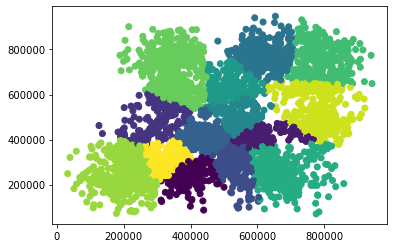

In [125]:
run_fuzzy()